In this notebook I've implemented XGBoost and GAN for time series forecast of stock prices

**XGBoost**

Importing required libraries and set parameters required to build the model

In [ ]:
!pip install chart_studio

     |████████████████████████████████| 71kB 4.7MB/s 


In [ ]:
import chart_studio.plotly as py
import math
import matplotlib
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import seaborn as sns
import time

from datetime import date
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from xgboost import XGBRegressor

%matplotlib inline


#Setting parameters


H = 21                         # Forecast horizon, in days. Note there are about 252 trading days in a year
train_size = 252*3             # Use 3 years of data as train set. Note there are about 252 trading days in a year
val_size = 252                 # Use 1 year of data as validation set
N = 3                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14
#Setting train_val_size
train_val_size = train_size + val_size # Size of train+validation set
print("No. of days in train+validation set = " + str(train_val_size))

No. of days in train+validation set = 1008


Functions for validation metrics used for XGBoost

In [ ]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_mae(a, b):
    """
    Comp mean absolute error e_t = E[|a_t - b_t|]. a and b can be lists.
    Returns a vector of len = len(a) = len(b)
    """
    return np.mean(abs(np.array(a)-np.array(b)))

def get_rmse(a, b):
    """
    Comp RMSE. a and b can be lists.
    Returns a scalar.
    """
    return math.sqrt(np.mean((np.array(a)-np.array(b))**2))

1)Function to calculate Moving Average of stock prices  
2)Building the model

In [ ]:
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out

def scale_row(row, feat_mean, feat_std):
    """
    Given a pandas series in row, scale it to have 0 mean and var 1 using feat_mean and feat_std
    Inputs
        row      : pandas series. Need to scale this.
        feat_mean: mean  
        feat_std : standard deviation
    Outputs
        row_scaled : pandas series with same length as row, but scaled
    """
    # If feat_std = 0 (this happens if adj_close doesn't change over N days), 
    # set it to a small number to avoid division by zero
    feat_std = 0.001 if feat_std == 0 else feat_std
    
    row_scaled = (row-feat_mean) / feat_std
    
    return row_scaled

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          seed=100, \
                          n_estimators=100, \
                          max_depth=3, \
                          learning_rate=0.1, \
                          min_child_weight=1, \
                          subsample=1, \
                          colsample_bytree=1, \
                          colsample_bylevel=1, \
                          gamma=0):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use XGBoost here.
    Inputs
        X_train_scaled     : features for training. Scaled to have mean 0 and variance 1
        y_train_scaled     : target for training. Scaled to have mean 0 and variance 1
        X_test_scaled      : features for test. Each sample is scaled to mean 0 and variance 1
        y_test             : target for test. Actual values, not scaled.
        col_mean           : means used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        col_std            : standard deviations used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 
    Outputs
        rmse               : root mean square error of y_test and est
        mape               : mean absolute percentage error of y_test and est
        est                : predicted values. Same length as y_test
    '''

    model = XGBRegressor(seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
    
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Get predicted labels and scale back to original range
    est_scaled = model.predict(X_test_scaled)
    est = est_scaled * col_std + col_mean

    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(y_test, est))
    mape = get_mape(y_test, est)
    
    return rmse, mape, est

def pred_xgboost(model, series, N, H):
    """
    Do recursive forecasting using xgboost
    Inputs
        model : the xgboost model
        series: numpy array of shape (len(series),). The time series we want to do recursive forecasting on
        N     : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        H     : forecast horizon
    Outputs
        Times series of predictions. Numpy array of shape (H,).
    """
    forecast = series.copy()
    for n in range(H):
        est = model.predict(forecast[-N:].reshape(1,-1))
        forecast = np.append(forecast, est)

    return forecast[-H:]

Importing the dataframe

In [ ]:
df = pd.read_csv("/content/VTI_20130102_20181231.csv")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head()

,date,open,high,low,close,adj_close,volume,month
0,2013-01-02,74.529999,75.150002,74.500000,75.139999,66.997757,5037200,1
1,2013-01-03,75.120003,75.370003,74.839996,75.029999,66.899689,2634600,1
2,2013-01-04,75.139999,75.519997,74.989998,75.410004,67.238510,2512900,1
3,2013-01-07,75.180000,75.279999,74.949997,75.209999,67.060173,2511200,1
4,2013-01-08,75.110001,75.180000,74.699997,75.010002,66.881859,1407900,1


Visualisation, time trend can be easily seen

Text(0, 0.5, 'USD')

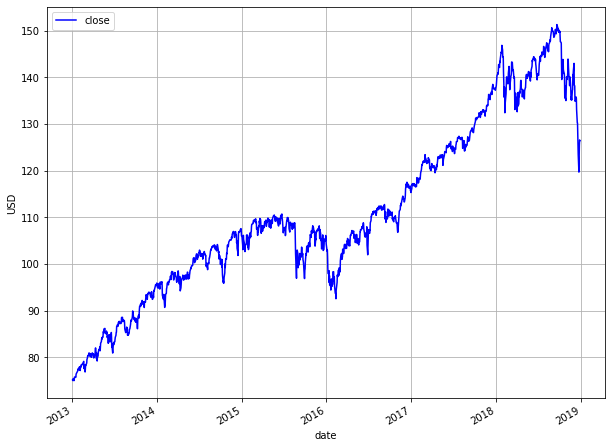

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

Removing the unneccessary columns

In [ ]:
# Remove columns which you can't use as features
df.drop(['open', 'high', 'low', 'adj_close', 'volume'], axis=1, inplace=True)

We use lags up to N number of days to use as features.

In [ ]:
# Add a column 'order_day' to indicate the order of the rows by date
df['order_day'] = [x for x in list(range(len(df)))]

# merging_keys
merging_keys = ['order_day']

# List of columns that we will use to create lags
lag_cols = ['close']
lag_cols

['close']

In [ ]:
shift_range = [x+1 for x in range(N)]

for shift in tqdm_notebook(shift_range):
    train_shift = df[merging_keys + lag_cols].copy()
    
    # E.g. order_day of 0 becomes 1, for shift = 1.
    # So when this is merged with order_day of 1 in df, this will represent lag of 1.
    train_shift['order_day'] = train_shift['order_day'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
del train_shift

# Remove the first N rows which contain NaNs
df = df[N:]
    
df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



,date,close,month,order_day,close_lag_1,close_lag_2,close_lag_3
3,2013-01-07,75.209999,1,3,75.410004,75.029999,75.139999
4,2013-01-08,75.010002,1,4,75.209999,75.410004,75.029999
5,2013-01-09,75.239998,1,5,75.010002,75.209999,75.410004
6,2013-01-10,75.760002,1,6,75.239998,75.010002,75.209999
7,2013-01-11,75.769997,1,7,75.760002,75.239998,75.010002


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1506 entries, 3 to 1508
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         1506 non-null   datetime64[ns]
 1   close        1506 non-null   float64       
 2   month        1506 non-null   int64         
 3   order_day    1506 non-null   int64         
 4   close_lag_1  1506 non-null   float64       
 5   close_lag_2  1506 non-null   float64       
 6   close_lag_3  1506 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 94.1 KB


Get mean and std dev at timestamp t using values from t-1, ..., t-N

In [ ]:
cols_list = ["close"]

for col in cols_list:
    df = get_mov_avg_std(df, col, N)
df.head()

,date,close,month,order_day,close_lag_1,close_lag_2,close_lag_3,close_mean,close_std
3,2013-01-07,75.209999,1,3,75.410004,75.029999,75.139999,NaN,NaN
4,2013-01-08,75.010002,1,4,75.209999,75.410004,75.029999,75.209999,NaN
5,2013-01-09,75.239998,1,5,75.010002,75.209999,75.410004,75.110000,0.141419
6,2013-01-10,75.760002,1,6,75.239998,75.010002,75.209999,75.153333,0.125031
7,2013-01-11,75.769997,1,7,75.760002,75.239998,75.010002,75.336667,0.384231


Predict for a specific H (forecast horizon) and a specific date

In [ ]:
i = 1008 # Predict for day i, for the next H-1 days. Note indexing of days start from 0.
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (i, df.iloc[i]['date'], H))

Predicting on day 1008, date 2017-01-06 00:00:00, with forecast horizon H = 21


Split into train, and test

In [ ]:
train = df[i-train_val_size:i]
test = df[i:i+H]
print("train.shape = " + str(train.shape))
print("test.shape = " + str(test.shape))

train.shape = (1008, 9)
test.shape = (21, 9)


Scale the train, and test set

In [ ]:
cols_to_scale = ["close"]

for n in range(1,N+1):
    cols_to_scale.append("close_lag_"+str(n))
    
# Do scaling for train set
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[cols_to_scale])
print("scaler.mean_ = " + str(scaler.mean_)) # Gives the mean of each column
print("scaler.var_ = " + str(scaler.var_))   # Give the var of each column

# Convert the numpy array back into pandas dataframe
train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
train_scaled[['date', 'month']] = train.reset_index()[['date', 'month']]
print("train_scaled.shape = " + str(train_scaled.shape))
train_scaled.head()

scaler.mean_ = [99.85261906 99.81149803 99.76977185 99.72903772]
scaler.var_ = [ 99.34734866  99.65140216  99.96273271 100.29507484]
train_scaled.shape = (1008, 6)


,close,close_lag_1,close_lag_2,close_lag_3,date,month
0,-2.472343,-2.444414,-2.474438,-2.455284,2013-01-07,1
1,-2.492408,-2.464449,-2.436431,-2.466268,2013-01-08,1
2,-2.469333,-2.484484,-2.456435,-2.428323,2013-01-09,1
3,-2.417162,-2.461444,-2.476438,-2.448294,2013-01-10,1
4,-2.416160,-2.409353,-2.453435,-2.468265,2013-01-11,1


Split into X and y

In [ ]:
features = []
for n in range(1,N+1):
    features.append("close_lag_"+str(n))

target = "close"

# Split into X and y
X_train = train[features]
y_train = train[target]
# X_sample = test[features]
# y_sample = test[target]
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
# print("X_sample.shape = " + str(X_sample.shape))
# print("y_sample.shape = " + str(y_sample.shape))

X_train.shape = (1008, 3)
y_train.shape = (1008,)


In [ ]:
# Split into X and y
X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled[target]
# X_sample_scaled = test_scaled[features]
print("X_train_scaled.shape = " + str(X_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))
# print("X_sample_scaled.shape = " + str(X_sample_scaled.shape))

X_train_scaled.shape = (1008, 3)
y_train_scaled.shape = (1008,)


Train the model using XGBoost

In [ ]:
# Create the model
model = XGBRegressor(objective ='reg:squarederror',
                     seed=model_seed,
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     min_child_weight=min_child_weight,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree,
                     colsample_bylevel=colsample_bylevel,
                     gamma=gamma)

# Train the regressor
model.fit(X_train_scaled.to_numpy(), y_train_scaled.to_numpy())

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=100, silent=None, subsample=1, verbosity=1)

Predict on train set

In [ ]:
# Do prediction on train set
est_scaled = model.predict(X_train_scaled.to_numpy())
est = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

# Calculate RMSE
print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train, est)))

# Calculate MAPE
print("MAPE on train set = %0.3f%%" % get_mape(y_train, est))

RMSE on train set = 0.669
MAPE on train set = 0.488%


Text(0.5, 1.0, 'Without scaling')

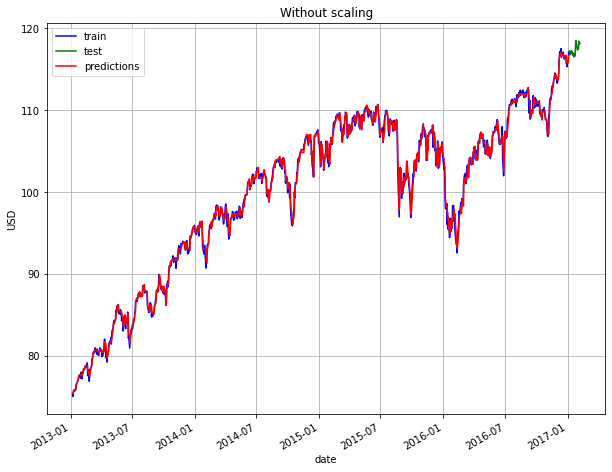

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'date': train['date']})

ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title('Without scaling')

Predict on test set using recursive forecasting

In [ ]:
# Do prediction on test set
est_scaled = pred_xgboost(model, train_scaled['close'].to_numpy(), N, H)
est = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

print("For forecast horizon %d, predicting on day %d, date %s, the RMSE is %f" % (H, i, df.iloc[i]['date'], get_rmse(df[i:i+H]['close'], est)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAPE is %f" % (H, i, df.iloc[i]['date'], get_mape(df[i:i+H]['close'], est)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAE is %f" % (H, i, df.iloc[i]['date'], get_mae(df[i:i+H]['close'], est)))

For forecast horizon 21, predicting on day 1008, date 2017-01-06 00:00:00, the RMSE is 0.948220
For forecast horizon 21, predicting on day 1008, date 2017-01-06 00:00:00, the mean MAPE is 0.651475
For forecast horizon 21, predicting on day 1008, date 2017-01-06 00:00:00, the mean MAE is 0.767399


Text(0, 0.5, 'USD')

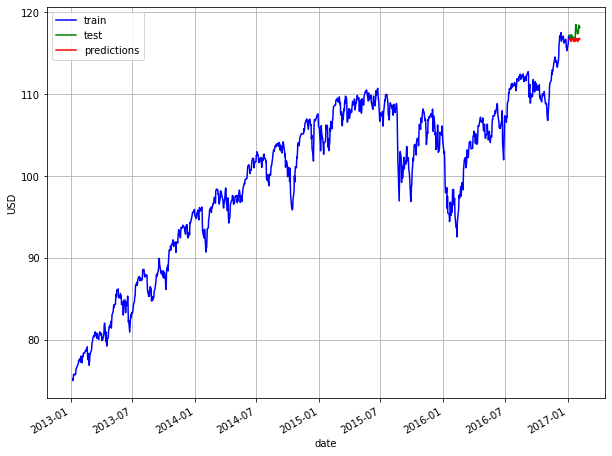

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'date': df[i:i+H]['date']})

ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [ ]:
# View a list of the features and their importance scores
imp = list(zip(train[features], model.feature_importances_))
imp.sort(key=lambda tup: tup[1]) 
imp[-10:]

[('close_lag_3', 0.012596778),
 ('close_lag_2', 0.08171536),
 ('close_lag_1', 0.90568787)]

As can be seen XGBoost model performs well on training data but doesn't perform well on test data

**GANS**

Importing required libraries

In [ ]:
import keras
from keras import layers
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import copy

Making input and forecast sequence

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

DataPreprocessing

In [ ]:
def data_preprocessing(step_size):
	
	df_final = pd.read_csv('/content/results_AAPL_new.csv')
	df_final.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Pct_change_raw', 'Compound_multiplied_raw']
	# avoid the data leakage problem
	df_final['Pct_change'] = df_final['Pct_change_raw'].shift(1)
	df_final.drop(['Pct_change_raw'], axis=1, inplace=True)
	df_final['Compound_multiplied'] = df_final['Compound_multiplied_raw'].shift(1)
	df_final.drop(['Compound_multiplied_raw'], axis=1, inplace=True)
	df_final.dropna(axis=0, how='any', inplace=True)
	dataset = df_final
	dataset['Date'] = pd.to_datetime(dataset.Date, format='%Y-%m-%d')
	dataset.index = dataset['Date']
	dataset = dataset.sort_index(ascending=True, axis=0)
	dataset.drop(['Date'], axis=1, inplace=True)
	
	values = dataset.values #67*6
	# ensure all data is float
	values = values.astype('float32')
	# normalize features
	scaler = MinMaxScaler(feature_range=(0, 1))
	scaled = scaler.fit_transform(values)
	
	# frame as supervised learning
	reframed = series_to_supervised(scaled, step_size, 1)  
	print(reframed.shape)
  # split into train and test sets
	values = reframed.values
	
	n_train_days = 61-1
	train = values[:n_train_days, :]
	test = values[n_train_days:, :]
	
	return train, test, scaler

In [ ]:
step_size = 5
feature_num = 6

Building generator

In [ ]:
generator_input = keras.Input(shape=(step_size,feature_num))
x = layers.LSTM(75,return_sequences=True)(generator_input)
#x = layers.Dropout(0.2)(x)
x = layers.LSTM(25)(x)
x = layers.Dense(1)(x)
x = layers.LeakyReLU()(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 6)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 5, 75)             24600     
_________________________________________________________________
lstm_1 (LSTM)                (None, 25)                10100     
_________________________________________________________________
dense (Dense)                (None, 1)                 26        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1)                 0         
Total params: 34,726
Trainable params: 34,726
Non-trainable params: 0
_________________________________________________________________


Building discriminator

In [ ]:
discriminator_input = layers.Input(shape=(step_size+1,1))
y = layers.Dense(72)(discriminator_input)
y = layers.LeakyReLU(alpha=0.05)(y)
y = layers.Dense(100)(y)
y = layers.LeakyReLU(alpha=0.05)(y)
y = layers.Dense(10)(y)
y = layers.LeakyReLU(alpha=0.05)(y)
y = layers.Dense(1,activation='sigmoid')(y)
discriminator = keras.models.Model(discriminator_input, y)
discriminator.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 6, 1)]            0         
_________________________________________________________________
dense_1 (Dense)              (None, 6, 72)             144       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 6, 72)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 6, 100)            7300      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6, 100)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 6, 10)             1010      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 6, 10)            

In [ ]:
discriminator_optimizer = keras.optimizers.RMSprop(lr=8e-4, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

In [ ]:
discriminator.trainable = False
gan_input = keras.Input(shape=(step_size, feature_num))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)
gan_optimizer = keras.optimizers.RMSprop(lr=4e-4, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

Defining training and test set

In [ ]:
train,test,scaler = data_preprocessing(step_size)
# split into input and outputs
n_obs = step_size * feature_num
train_X, train_Y = train[:, :n_obs], train[:, -feature_num] #choose the first feature,namely 'open price'
test_X, test_Y = test[:, :n_obs], test[:, -feature_num]  # !!!!!!!!!!!!!!!
print(train_X.shape, len(train_X), train_Y.shape) 
# reshape input to be 3D [samples, timesteps, features]
trainX = train_X.reshape((train_X.shape[0], step_size, feature_num))
testX = test_X.reshape((test_X.shape[0], step_size, feature_num))

(65, 36)
(60, 30) 60 (60,)


Training GAN

In [ ]:
iterations = 61-1
batch_size = 1
start = 0
final = []

for step in range(iterations):
	print(step)
	temp_X = copy.deepcopy(trainX[step])
	temp_X = temp_X.reshape(batch_size,step_size,feature_num)
	temp_Y = copy.deepcopy(train_Y[step])
	temp_Y = temp_Y.reshape(batch_size,1)
	predictions = generator.predict(temp_X)
	
	for i in range(25):
		aaa = trainX[step]
		input_f = np.concatenate([np.transpose(np.array([aaa[:,0]])), predictions], 0)
		input_r = np.concatenate([np.transpose(np.array([aaa[:,0]])), temp_Y], 0)
		input = np.concatenate([[input_f],[input_r]])
		labels = np.concatenate([[np.ones((6, 1))], [np.zeros((6, 1))]])
		d_loss = discriminator.train_on_batch(input, labels)
	
	for i in range(5):
		misleading_targets = np.zeros((batch_size, 1))
		a_loss = gan.train_on_batch(temp_X, [misleading_targets])
	final.append(predictions[0])
final = np.concatenate((np.array(final), train_X[:, -5:]), axis=1)
final2 = np.concatenate((np.transpose(np.array([train_Y])), train_X[:, -5:]), axis=1)
int1 = scaler.inverse_transform(final)
int2 = scaler.inverse_transform(final2)
MAPE_O1 = np.mean(np.abs((int2[:,0] - int1[:,0]) / int2[:,0]))
rmse_01 = math.sqrt(np.mean(np.array(int2[:,0]-int1[:,0])**2))
print('training result: MAPE',MAPE_O1)
print('training result: MSE',rmse_01)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
training result: MAPE 0.013570619
training result: MSE 2.100397403898362


Prediction on test data

In [ ]:
final = []
for step in range(5):
	temp_X = copy.deepcopy(testX[step])
	temp_X = temp_X.reshape(batch_size, step_size, feature_num)
	predictions = generator.predict(temp_X)
	final.append(predictions[0])

final = np.concatenate((np.array(final), test_X[:, -5:]), axis=1)
final2 = np.concatenate((np.transpose(np.array([test_Y])), test_X[:, -5:]), axis=1)
int1 = scaler.inverse_transform(final)
int2 = scaler.inverse_transform(final2)
MAPE_O2 = np.mean(np.abs((int2[:,0] - int1[:,0]) / int2[:,0]))
rmse_02 = math.sqrt(np.mean(np.array(int2[:,0]-int1[:,0])**2))
print('testing result mape:',MAPE_O2)
print('testing results rmse: ',rmse_02)

testing result mape: 0.009761118
testing results rmse:  1.0980244626445241
